References for map plot:

Interactive map plots with Plotly: https://towardsdatascience.com/how-to-create-interactive-map-plots-with-plotly-7b57e889239a

Changed the dataset; customized layout, different color for data analysis and visualization; added different ways of interaction

Mapbox Choropleth Maps in Python: https://plot.ly/python/mapbox-county-choropleth/

Adapted layers from the code

In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import pandas as pd
import numpy as np

The combined data have coordinates in one column, need to separate them to latitude and longitude first

In [2]:
# load data
df1 = pd.read_csv('./data/Final_Data.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5492 entries, 0 to 5491
Data columns (total 6 columns):
Language                 5492 non-null object
Level of Endangerment    5492 non-null object
Number of Speakers       5309 non-null object
Linguistic Family        5492 non-null object
Countries                5491 non-null object
Coordinates              5492 non-null object
dtypes: object(6)
memory usage: 257.5+ KB


In [3]:
# store rows to be added
new_rows = []
# store index of all the rows that need to be droped
drop_index = []
# iterate through the DataFrame
i = 0
for i in range(len(df1)):
    # check if the row have multiple coordinates
    coors = df1.iloc[i]['Coordinates'].split(';')
    if len(coors) > 1:
        drop_index.append(i)
        for coor in coors:
            # generate new row to be added to the DataFrame
            new_row = [df1.iloc[i]['Language'],
                       df1.iloc[i]['Level of Endangerment'],
                       df1.iloc[i]['Number of Speakers'],
                       df1.iloc[i]['Linguistic Family'],
                       df1.iloc[i]['Countries'],
                       coor]
            # store new row
            new_rows.append(new_row)

In [4]:
# drop the rows with multiple coordinates in one cell
df1 = df1.drop(df1.index[drop_index])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5301 entries, 1 to 5491
Data columns (total 6 columns):
Language                 5301 non-null object
Level of Endangerment    5301 non-null object
Number of Speakers       5118 non-null object
Linguistic Family        5301 non-null object
Countries                5300 non-null object
Coordinates              5301 non-null object
dtypes: object(6)
memory usage: 289.9+ KB


In [5]:
# append the new rows to the end of original DataFrame
df2 = pd.DataFrame(new_rows, columns=['Language', 'Level of Endangerment', 'Number of Speakers', 'Linguistic Family', 'Countries', 'Coordinates'])
df1 = df1.append(df2, ignore_index = True) 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
Language                 5822 non-null object
Level of Endangerment    5822 non-null object
Number of Speakers       5639 non-null object
Linguistic Family        5822 non-null object
Countries                5821 non-null object
Coordinates              5822 non-null object
dtypes: object(6)
memory usage: 273.0+ KB


In [6]:
# Separate the Coordinate column into Latitude and Longitude column
lat = []
lon = []
# interate over the DataFrame and store latitude and longitude data in lists
for index, row in df1.iterrows():
    coor = row['Coordinates'].split(',')
    if len(coor) == 2:
        lat.append(coor[0])
        lon.append(coor[1])
    else:
        lat.append(None),
        lon.append(None)
        
# turn lists into Series
se_lat = pd.Series(lat)
se_lon = pd.Series(lon)

# add new columns into DataFrame
df1['Latitude'] = se_lat.values
df1['Longitude'] = se_lon.values

# drop rows with null latitude and longitude
df1 = df1[pd.notnull(df1['Latitude'])]
df1 = df1[pd.notnull(df1['Countries'])]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5763 entries, 0 to 5821
Data columns (total 8 columns):
Language                 5763 non-null object
Level of Endangerment    5763 non-null object
Number of Speakers       5580 non-null object
Linguistic Family        5763 non-null object
Countries                5763 non-null object
Coordinates              5763 non-null object
Latitude                 5763 non-null object
Longitude                5763 non-null object
dtypes: object(8)
memory usage: 405.2+ KB


The UNESCO scale have five level of endangerment: Vulnerable, Definitely endangered, Severely endangered, Critically endangered, and Extinct.

Classify At Risk and Threatened into Vulnerable; Endangered into Definitely endangered; Severely Endangered into Severely endangered; Critically Endangered into Critically endangered; Dormant into Extinct.

There is only one data in Awakening, so I will leave that.

In [7]:
# change level of endangerment into a same scale (UNESCO scale)
# different level of endangerment in the data
levels = list(df1['Level of Endangerment'].value_counts().index)
levels

['Vulnerable',
 'Threatened',
 'Endangered',
 'Definitely endangered',
 'Critically endangered',
 'Severely endangered',
 'Critically Endangered',
 'Severely Endangered',
 'Extinct',
 'At Risk',
 'Dormant',
 'Awakening ()']

In [8]:
# unify endangerment scales
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace(['At Risk', 'Threatened'], 'Vulnerable')
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace('Endangered', 'Definitely Endangered')
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace('Definitely endangered', 'Definitely Endangered')
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace('Severely endangered', 'Severely Endangered')
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace('Critically endangered', 'Critically Endangered')
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace('Dormant', 'Extinct')
df1['Level of Endangerment'] = df1['Level of Endangerment'].replace('Awakening ()', 'Awakening')

levels1 = list(df1['Level of Endangerment'].value_counts().index)
levels1

['Vulnerable',
 'Definitely Endangered',
 'Critically Endangered',
 'Severely Endangered',
 'Extinct',
 'Awakening']

In [9]:
# export as csv file
export_csv = df1.to_csv ('./data/degree_map_data.csv', index = None, header=True)

Using the wrangled data to plot the map

In [10]:
# setting user, api key and access token
plotly.tools.set_credentials_file(username='WendyLiang', api_key='0Mqn1LRKjujs81acpAGt')
mapbox_access_token = 'pk.eyJ1Ijoid2VuZHlsaWFuZyIsImEiOiJjandhZGVzd3cwOHU0NGFuMHBzdHJvNHdhIn0.15zho30YkMBcHvlAVx4J9w'

# load data
df = pd.read_csv('./data/degree_map_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5763 entries, 0 to 5762
Data columns (total 8 columns):
Language                 5763 non-null object
Level of Endangerment    5763 non-null object
Number of Speakers       5580 non-null object
Linguistic Family        5763 non-null object
Countries                5763 non-null object
Coordinates              5763 non-null object
Latitude                 5760 non-null float64
Longitude                5760 non-null object
dtypes: float64(1), object(7)
memory usage: 360.3+ KB


In [11]:
# drop rows with no coordinate info
df = df[pd.notnull(df['Latitude'])]
df = df[pd.notnull(df['Countries'])]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5762
Data columns (total 8 columns):
Language                 5760 non-null object
Level of Endangerment    5760 non-null object
Number of Speakers       5577 non-null object
Linguistic Family        5760 non-null object
Countries                5760 non-null object
Coordinates              5760 non-null object
Latitude                 5760 non-null float64
Longitude                5760 non-null object
dtypes: float64(1), object(7)
memory usage: 405.0+ KB


Data Visualization with Map Plot

In [12]:
# there are five level of endangerment in the data
degrees = ['Vulnerable', 'Definitely Endangered', 'Severely Endangered', 'Critically Endangered', 'Extinct', 'Awakening']

# represent each degree of endangerment with a different color
colors = ["rgb(81,235,147)", "rgb(81,112,235)", "rgb(209,81,235)", "rgb(235,81,81)", "rgb(47,60,60)", "rgb(255,215,0)"]

In [13]:
# put data of the plot in a dictionary
data = []
for i in range(len(degrees)):
    degree = degrees[i]
    degree_data = go.Scattermapbox(
        # we need coordinate, endangerment level and name of the languages
        lat = df.loc[df['Level of Endangerment'] == degree, 'Latitude'],
        lon = df.loc[df['Level of Endangerment'] == degree, 'Longitude'],
        text = df.loc[df['Level of Endangerment'] == degree, ['Language', 'Number of Speakers']],
        mode = 'markers',
        marker = go.scattermapbox.Marker(
            # size and color of each dot
            size = 8,
            opacity = 1,
            color = colors[i]
        ),
        name = degree,
        # display name of the language when hover over
        # uncomment the next line map will not display coordinates information
        # hoverinfo = 'text',
        type = 'scattermapbox'
    )
    data.append(degree_data)

In [14]:
# layout of the map
layout = go.Layout(
    height = 800,
    hovermode='closest',
    # top, bottom, left and right margins
    margin = dict(t = 1.5, b = 1, l = 1, r = 1),
    font = dict(color = '#000000', size = 11),
    paper_bgcolor = '#FFFFFF',
    mapbox = dict(
        accesstoken = mapbox_access_token,
        bearing = 0,
        # center the map at the US at beginning
        center = dict(
            lat = 38,
            lon = -94
        ),
        pitch = 0, # set the map to be "parallel" to our screen, with no angle
        zoom = 3, # default level of zoom
        style = 'light' # default map style
    )
)

In [15]:
# relayout the map when different continents are selected
# center the map on the coresponsing continent
# color the continent area in dark gray
# Africa
center_africa = dict(
    lat = 9,
    lon = 35
)
layers_africa = [dict(
    sourcetype = 'geojson',
    source = 'https://raw.githubusercontent.com/wendyrliang/Endangered_Languages/master/data/africa.json?token=AJWK76ZRV6JFOSIZOHPADV25ACL7Q',
    type = 'fill',
    color = 'rgba(96,96,96,0.4)',
    below = 'state-label-sm'
)]
    
# Asia
center_asia = dict(
    lat = 34,
    lon = 101
)
layers_asia = [dict(
    sourcetype = 'geojson',
    source = 'https://raw.githubusercontent.com/wendyrliang/Endangered_Languages/master/data/asia.json?token=AJWK767HG4ADK4YDPYVHOPS5ACMBS',
     type = 'fill',
    color = 'rgba(96,96,96,0.4)',
    below = 'state-label-sm'
)]

# Europe
center_europe = dict(
    lat = 55,
    lon = 15
)
layers_europe = [dict(
    sourcetype = 'geojson',
    source = 'https://raw.githubusercontent.com/wendyrliang/Endangered_Languages/master/data/europe.json?token=AJWK7673N5BGJPICCPMKU3S5ACMFA',
    type = 'fill',
    color = 'rgba(96,96,96,0.4)',
    below = 'state-label-sm'
)]

# North America
center_namerica = dict(
    lat = 54,
    lon = -105
)
layers_namerica = [dict(
    sourcetype = 'geojson',
    source = 'https://raw.githubusercontent.com/wendyrliang/Endangered_Languages/master/data/n_america.json?token=AJWK767XOGIMWSQGQGA5XRC5ACMH2',
    type = 'fill',
    color = 'rgba(96,96,96,0.4)',
    below = 'state-label-sm'
)]

# South America
center_samerica = dict(
    lat = 9,
    lon = -55
)
layers_samerica = [dict(
    sourcetype = 'geojson',
    source = 'https://raw.githubusercontent.com/wendyrliang/Endangered_Languages/master/data/s_america.json?token=AJWK762IMJASUEGB7W5DJSK5ACMLQ',
    type = 'fill',
    color = 'rgba(96,96,96,0.4)',
    below = 'state-label-sm'
)]

# Australia
center_australia = dict(
    lat = -23,
    lon = 140
)
layers_australia = [dict(
    sourcetype = 'geojson',
    source = 'https://raw.githubusercontent.com/wendyrliang/Endangered_Languages/master/data/oceania.json?token=AJWK762FSEKMZGAHEJTM7GC5ACMNM',
    type = 'fill',
    color = 'rgba(96,96,96,0.4)',
    below = 'state-label-sm'
)]

# Awakening
center_awakening = dict(
    lat = -34.35,
    lon = 138.48
    
)

In [16]:
# dorp-downs for visulization
updatemenus=list([
    # drop-down 1: select different degrees to visualize
    dict(
         buttons=list([
            dict(label = 'All Degrees',
                 method = 'update',
                 args = [{'visible': [True, True, True, True, True, True]}]),
            dict(label = 'Vulnerable',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False]}]),
            dict(label = 'Definitely Endangered',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False]}]),
             dict(label = 'Severely Endangered',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False]}]),
             dict(label = 'Critically Endangered',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False]}]),
             dict(label = 'Extinct',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False]}]),
             dict(label = 'Awakening',
                 method = 'relayout',
                 args = [{'mapbox.center' : center_awakening,
                          'mapbox.zoom' : 5}])
             
        ]),
        # direction where the drop-down expands when opened
        direction = 'down',
        # positional arguments
        x = 0.01,
        xanchor = 'left',
        y = 0.99,
        yanchor = 'bottom',
        # fonts and border
        bgcolor = '#FFFFFF',
        bordercolor = '#000000',
        font = dict(size=11)
    ),
    
    # drop-down 2: select different continent
    dict(
        buttons = list([
            dict(
                label = 'North America',
                method = 'relayout',
                args = [{
                    'mapbox.center' : center_namerica,
                    'mapbox.layers' : layers_namerica,
                    'mapbox.zoom' : 2
                }]
            ),
            dict(
                label = 'South America',
                method = 'relayout',
                args = [{
                    'mapbox.center' : center_samerica,
                    'mapbox.layers' : layers_samerica,
                    'mapbox.zoom' : 2
                }]
            ),
            dict(
                label = 'Asia',
                method = 'relayout',
                args = [{
                    'mapbox.center' : center_asia,
                    'mapbox.layers': layers_asia,
                    'mapbox.zoom' : 2
                }]
            ),
            dict(
                label = 'Africa',
                method = 'relayout',
                args = [{
                    'mapbox.center' : center_africa,
                    'mapbox.layers' : layers_africa,
                    'mapbox.zoom' : 2
                }]
            ),
            dict(
                label = 'Europe',
                method = 'relayout',
                args = [{
                    'mapbox.center' : center_europe,
                    'mapbox.layers' : layers_europe,
                    'mapbox.zoom' : 2
                }]
            ),
            dict(
                label = 'Australia',
                method = 'relayout',
                args = [{
                    'mapbox.center' : center_australia,
                    'mapbox.layers' : layers_australia,
                    'mapbox.zoom' : 2
                }]
            )
        ]),
        # direction where I want the menu to expand when I click on it
        direction = 'up',
      
        # here I specify where I want to place this drop-down on the map
        x = 0.80,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
      
        # specify font size and colors
        bgcolor = '#FFFFFF',
        bordercolor = '#000000',
        font = dict(size=11)
    )
])

# assign the list of dictionaries to the global layout dictionary
layout['updatemenus'] = updatemenus

In [17]:
# display mapy name
annotations = [dict(
              text = 'Endangered Languages Around the World',
              font = dict(color = '#000000', size = 14), borderpad = 10,
              x = 0.05, y = 0.05, xref = 'paper', yref = 'paper', align = 'left',
              showarrow = False, bgcolor = '#FFFFFF'
              )]

# assigning the annotations to the layout
layout['annotations'] = annotations

In [18]:
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Global_EL_degree')

/usr/local/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [19]:
plotly.offline.plot(fig, filename='Global_EL_degree', auto_open=False)

/usr/local/lib/python3.7/site-packages/plotly/offline/offline.py:524: UserWarning:

Your filename `Global_EL_degree` didn't end with .html. Adding .html to the end of your file.



'Global_EL_degree.html'

Data Analysis

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# count number of endangered languages for each degree of endangerment
# only count unique name of languages
degree = df.groupby('Level of Endangerment')['Language'].nunique()
degree

Level of Endangerment
Awakening                   1
Critically Endangered     874
Definitely Endangered    1296
Extinct                   317
Severely Endangered       811
Vulnerable               1793
Name: Language, dtype: int64

Text(0.5, 1.0, 'Endangered languages and degree of endangerment')

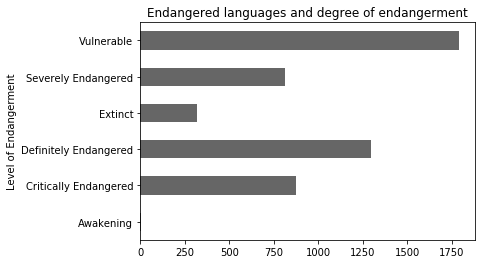

In [22]:
# create a bar plot for different degree of endangerment
plt.figure()
degree_bar = degree.plot.barh(x = 'Level of Endangerment', color='k', alpha=0.6)
plt.title('Endangered languages and degree of endangerment')
# Saving the bar plot as pdf file
# plt.savefig('degree_bar.pdf')